Verify whether oversampling-before-split inflates performance on CDC's BRFSS dataset.
Replicating : https://pmc.ncbi.nlm.nih.gov/articles/PMC11678659/

The script runs two experiments using BRFSS (2021):

A) "LEAKY": SMOTE-ENN is applied to the dataset BEFORE the train/test split.

B) "PROPER": Split first; oversampling (SMOTE-ENN) happens ONLY inside the training pipeline.

C) "PROPER": undersampling.


In [1]:
# https://www.cdc.gov/brfss/annual_data/annual_data.htm
# datafile downloaded from: https://www.cdc.gov/brfss/annual_data/2021/files/LLCP2021XPT.zip


# Update path to reflect file location
XPT_PATH = r"C:\Users\meltawil\Rutgers University\DOPPS Data Kidney Project - General\6.0 Team Working Folders\Mohamed\Data Leakage Test"


random_state = 42
TEST_SIZE = 0.30


# to check pipeline, set to 0.1 or 0.2 (10% or 20%) to reduce the size of training and testing by that factorto speed up processing
SUBSAMPLE_FRAC = 0.2   


### 1) IMPORTS

In [2]:
import os
import warnings
import time
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
)

from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler


### 2) HELPER FUNCTIONS

In [3]:
def recode_alcday5(series):
    """Recode ALCDAY5 to approximate drinks per month."""
    s = pd.to_numeric(series, errors="coerce")
    out = pd.Series(np.nan, index=s.index, dtype="float")

    # Days per week (101–107)
    mask_week = s.between(101, 107)
    out[mask_week] = (s[mask_week] - 100) * 4.345  # weeks → ~days/month

    # Days in past 30 days (201–230)
    mask_month = s.between(201, 230)
    out[mask_month] = s[mask_month] - 200

    # No drinks in past 30 days
    out[s == 888] = 0

    # 777, 999, NaN → leave as NaN
    return out


def recode_food_frequency(series):
    """Recode FRUIT2, FVGREEN1, FRENCHF1 to times per month."""
    s = pd.to_numeric(series, errors="coerce")
    out = pd.Series(np.nan, index=s.index, dtype="float")

    # 101–199: per day → ×30
    mask = (s >= 101) & (s <= 199)
    out[mask] = (s[mask] - 100) * 30

    # 201–299: per week → ×4.3
    mask = (s >= 201) & (s <= 299)
    out[mask] = (s[mask] - 200) * 4.3

    # 300: less than once per month
    out[s == 300] = 0.5

    # 301–399: per month
    mask = (s >= 301) & (s <= 399)
    out[mask] = s[mask] - 300

    # 555: Never
    out[s == 555] = 0

    # 777, 999 → NaN
    out[s.isin([777, 999])] = np.nan

    return out


def prepare_brfss_dataset(df):
    """
    Prepare BRFSS dataset for ML using the 18-paper-variable setup.
    Works for BRFSS 2021, 2022, 2023 (if vars exist).
    Returns: X (features), y (target).
    """

    # Target: Heart disease (_MICHD)
    y = df["_MICHD"].replace({1: 1,2: 0, 7: np.nan, 9: np.nan})
    y.name = "Heart_Disease"

    # Features
    X = pd.DataFrame(index=df.index)
    X["General_Health"] = df["GENHLTH"].replace({1: 1, 2: 2, 3: 3, 4: 4, 5: 5,7: np.nan, 9: np.nan})
    X["Checkup"] = df["CHECKUP1"].replace({1: 4, 2: 3, 3: 2, 4: 1,7: np.nan, 8: 0, 9: np.nan})
    X["Exercise"] = df["EXERANY2"].replace({1: 1, 2: 0, 7: np.nan, 9: np.nan})
    X["Skin_Cancer"] = df["CHCSCNCR"].replace({1: 1, 2: 0, 7: np.nan, 9: np.nan})
    X["Other_Cancer"] = df["CHCOCNCR"].replace({1: 1, 2: 0, 7: np.nan, 9: np.nan})
    X["Depression"] = df["ADDEPEV3"].replace({1: 1, 2: 0, 7: np.nan, 9: np.nan})
    X["Diabetes"] = df["DIABETE4"].replace({1: 1, 2: 0, 3: 0, 4: 0, 7: np.nan, 9: np.nan})
    X["Arthritis"] = df["HAVARTH5"].replace({1: 1, 2: 0, 7: np.nan, 9: np.nan})
    X["Sex"] = df["SEXVAR"]
    X["Age_Category"] = df["_AGEG5YR"].replace({
        1: 12, 2: 11, 3: 10, 4: 9, 5: 8, 6: 7,
        7: 6, 8: 5, 9: 4, 10: 3, 11: 2, 12: 1, 13: 0,
        14: np.nan
    })
    X["Height_cm"] = pd.to_numeric(df.get("HTM4"), errors="coerce")
    X["Weight_kg"] = pd.to_numeric(df.get("WTKG3"), errors="coerce") * 0.01
    X["BMI"] = X["Weight_kg"] / ((X["Height_cm"] * 0.01) ** 2)
    X["Smoking_History"] = df["SMOKE100"].replace({1: 1, 2: 0, 7: np.nan, 9: np.nan})
    X["Alcohol_Consumption"] = recode_alcday5(df["ALCDAY5"])
    X["Fruit_Consumption"] = recode_food_frequency(df["FRUIT2"])
    X["Green_Vegetables_Consumption"] = recode_food_frequency(df["FVGREEN1"])
    X["FriedPotato_Consumption"] = recode_food_frequency(df["FRENCHF1"])

    return X, y


In [4]:
def clean_brfss_dataset(X, y, drop_na=True, drop_dupes=True,
                        height_range=(140, 210), weight_range=(45, 200),
                        verbose=True):
    """
    Clean BRFSS dataset after feature/target preparation.
    - Drops duplicate rows
    - Optionally drops rows with NaNs
    - Applies height/weight plausibility filters
    - Returns cleaned (X, y)
    """

    # Combine into single DataFrame
    df_xy = pd.concat([X, y], axis=1)

    n_before = len(df_xy)

    if drop_dupes:
        df_xy = df_xy.drop_duplicates()
    n_after_dupes = len(df_xy)

    if drop_na:
        df_xy = df_xy.dropna()
    n_after_na = len(df_xy)

    # Apply range filters
    mask = (
        df_xy["Height_cm"].between(*height_range) &
        df_xy["Weight_kg"].between(*weight_range)
    )
    df_xy = df_xy[mask]
    n_after_range = len(df_xy)

    # Split back
    X_clean = df_xy.drop(columns=["Heart_Disease"])
    y_clean = df_xy["Heart_Disease"]

    if verbose:
        print(f"Initial rows: {n_before:,}")
        if drop_dupes:
            print(f"After dropping duplicates: {n_after_dupes:,} (removed {n_before - n_after_dupes:,})")
        if drop_na:
            print(f"After dropping NaNs: {n_after_na:,} (removed {n_after_dupes - n_after_na:,})")
        print(f"After filtering Height[{height_range[0]}–{height_range[1]}] & "
              f"Weight[{weight_range[0]}–{weight_range[1]}]: {n_after_range:,} "
              f"(removed {n_after_na - n_after_range:,})")
        print("\n")

    return X_clean, y_clean


In [5]:
def split_brfss_dataset(X, y, test_size=TEST_SIZE, subsample_frac=SUBSAMPLE_FRAC,
                        random_state=random_state, verbose=True):
    """
    Prepares BRFSS dataset for ML:
    - Drops rows with missing labels (NaN in y)
    - Optionally subsamples while preserving class balance
    - Splits into train/test sets with stratification
    """

    # Drop NaN labels
    mask = y.notna()
    X = X.loc[mask].reset_index(drop=True)
    y = y.loc[mask].astype(int).reset_index(drop=True)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    if verbose:
        def summarize_balance(name, y_arr):
            p = float((y_arr == 1).mean())
            n = len(y_arr)
            print(f"{name:>10s}  n={n:>8d}  positives={p*100:5.2f}%  (class balance)")
        print("\n=== Class balance (original and splits) ===")
        summarize_balance("ALL", y)
        summarize_balance("TRAIN", y_train)
        summarize_balance("TEST", y_test)
        print("\n")

    return X_train, X_test, y_train, y_test


In [6]:
def make_knn_pipeline(leaky=False):
    KNN_args = {"n_neighbors":2,
                "metric":"euclidean",
                "weights":"uniform",
                "algorithm":"brute"}
    
    if leaky:
        return ImbPipeline([
            ("scaler", MinMaxScaler()),
            ("to32", FunctionTransformer(lambda x: x.astype(np.float32))),
            ("clf", KNeighborsClassifier(**KNN_args)),        
            ])
    else:
        return ImbPipeline([
            ("scaler", MinMaxScaler()),
            ("smoteenn", smoteenn),                         
            ("to32", FunctionTransformer(lambda x: x.astype(np.float32))),
            ("clf", KNeighborsClassifier(**KNN_args)),        
            ])



def evaluate(pipe, Xval, yval, label):
    preds = pipe.predict(Xval)

    # Ensure y is 0/1 binary
    y_bin = np.array(yval).ravel()

    proba, auc, fpr, tpr = None, np.nan, [], []
    if hasattr(pipe, "predict_proba"):
        try:
            raw_proba = pipe.predict_proba(Xval)
            if raw_proba.ndim == 2 and raw_proba.shape[1] > 1:
                proba = raw_proba[:, 1]
            else:
                proba = raw_proba.ravel()

            auc = roc_auc_score(y_bin, proba)
            fpr, tpr, _ = roc_curve(y_bin, proba)

            print(f"[{label}] ROC computed: {len(fpr)} points")
        except Exception as e:
            print(f"[{label}] ROC failed: {e}")

    acc = accuracy_score(yval, preds)
    f1  = f1_score(yval, preds)
    cm  = confusion_matrix(yval, preds)
    cr  = classification_report(yval, preds, digits=3, output_dict=True)

    return {
        "label": label,
        "accuracy": acc,
        "f1": f1,
        "auc": auc,
        "confusion_matrix": cm,
        "classification_report": cr,
        "fpr": fpr,   # always return (even if empty)
        "tpr": tpr
    }


In [7]:
def build_comparison_table(results_dict):
    """
    Build a comparison DataFrame from evaluate() outputs.
    results_dict: dict of {model_name: evaluate_output}
    """
    rows = []
    for name, res in results_dict.items():
        cr = res["classification_report"]

        # Find the positive class key (exclude 'accuracy', 'macro avg', 'weighted avg')
        class_keys = [k for k in cr.keys() if k not in ["accuracy", "macro avg", "weighted avg"]]
        if len(class_keys) == 2:
            # assume binary: take the positive class as the *larger* label
            pos_class = sorted(class_keys)[-1]
        else:
            # fallback: just take the last class
            pos_class = class_keys[-1]

        rows.append({
            "Method": name.upper(),
            "AUC": res["auc"],
            "ACC": res["accuracy"],
            "F1": res["f1"],
            "Precision": cr[pos_class]["precision"],
            "Recall": cr[pos_class]["recall"],
            "Specificity": res["confusion_matrix"][0,0] / res["confusion_matrix"][0].sum()
        })

    df = pd.DataFrame(rows)
    return df.set_index("Method")


def plot_all_rocs(results_dict, title="ROC Curves Comparison"):
    plt.figure(figsize=(8,6))
    for name, res in results_dict.items():
        fpr, tpr, auc = res.get("fpr"), res.get("tpr"), res.get("auc")
        if fpr is not None and tpr is not None and len(fpr) > 0:
            plt.plot(fpr, tpr, label=f"{name.upper()} (AUC={auc:.4f})")
        else:
            print(f"[{name.upper()}] No ROC curve data available.")
    plt.plot([0,1],[0,1],"k--",label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()



In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# NEW: use SciKeras wrapper instead of the removed TF one
# from scikeras.wrappers import KerasClassifier
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization


# def build_ann(input_dim=None):
#     """ANN architecture per paper (binary classification)."""
#     model = Sequential()
#     model.add(Dense(128, activation="relu", input_dim=input_dim))
#     model.add(Dropout(0.3))
#     model.add(BatchNormalization())
#     model.add(Dense(64, activation="relu"))
#     model.add(Dropout(0.3))
#     model.add(BatchNormalization())
#     model.add(Dense(1, activation="sigmoid"))

#     model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
#     return model



def make_pipeline(model_name="knn", leaky=False, smoteenn=None):
    """
    Build an imbalanced pipeline with classifier chosen by `model_name`.

    Parameters
    ----------
    model_name : str
        One of: 'knn', 'rf', 'lr', 'nb', 'svc', 'xgb', 'ann'
    leaky : bool
        If True, skip SMOTE–ENN step.
    smoteenn : transformer
        SMOTE-ENN object (or any sampler) to insert if not leaky.
    """

    clf_dict = {
        "knn": KNeighborsClassifier(
            n_neighbors=2, metric="euclidean", weights="uniform", algorithm="brute"
        ),
        "rf": RandomForestClassifier(
            n_estimators=300, max_depth=None,
            min_samples_split=2, min_samples_leaf=1, random_state=42
        ),
        "lr": LogisticRegression(
            solver="saga", penalty="l1", max_iter=500, C=0.08858667904100823
        ),
        "xgb": XGBClassifier(
            colsample_bytree=1.0, learning_rate=0.2, max_depth=7,
            n_estimators=300, subsample=0.9,
            reg_alpha=0.5, reg_lambda=0.5, use_label_encoder=False,
            eval_metric="logloss", random_state=42
        ),
        # "nb": GaussianNB(var_smoothing=1e-7, priors=[0.3, 0.7]),
        # "svc": SVC(kernel="rbf", probability=True, random_state=42),
        # "ann": KerasClassifier(
        #     model=build_ann,
        #     model__input_dim=X.shape[1],  # <-- tell SciKeras how many features
        #     epochs=50,
        #     batch_size=32,
        #     verbose=0
        # ),        
    }

    if model_name not in clf_dict:
        raise ValueError(f"Unknown model_name: {model_name}")

    steps = [("scaler", MinMaxScaler())]

    if not leaky and smoteenn is not None:
        steps.append(("smoteenn", smoteenn))

    steps.extend([
        ("to32", FunctionTransformer(lambda x: x.astype(np.float32))),
        ("clf", clf_dict[model_name])
    ])

    return ImbPipeline(steps)


### 3) LOAD & PREPROCESS DATA

In [9]:
# ===== LOAD  ===== 
df = pd.read_sas(os.path.join(XPT_PATH, "LLCP2021.XPT"), format="xport", encoding="utf-8")
df.columns = [str(c).upper() for c in df.columns]
print(f"Rows: {len(df):,}, Columns: {len(df.columns):,}\n")

# ===== MAP FIELDS  ===== 
X, y = prepare_brfss_dataset(df)

# ===== Target distribution =====
counts = y.value_counts(dropna=False)
percentages = (counts / len(y) * 100).round(2)
# print("\nTarget distribution (Heart_Disease):")
print(pd.DataFrame({"Count": counts, "Percent": percentages}))
print("\n")

# ===== DATA CLEANING  ===== 
X_all, y_all = clean_brfss_dataset(X, y)

# ===== SUBSAMPLE  ===== 
if SUBSAMPLE_FRAC < 1.0:
    X, _, y, _ = train_test_split(X_all, y_all,test_size=(1 - SUBSAMPLE_FRAC),random_state=random_state,stratify=y_all)
    print(f"Subsampled dataset: {len(X):,} rows, positives={y.sum():,} ({y.mean()*100:.2f}%)\n")
else:
    X, y = X.copy(), y.copy()

# ===== DATA SPLITTING  ===== 
X_train, X_test, y_train, y_test = split_brfss_dataset(X, y)


Rows: 438,693, Columns: 303

                Count  Percent
Heart_Disease                 
0.0            398735    90.89
1.0             35323     8.05
NaN              4635     1.06


Initial rows: 438,693
After dropping duplicates: 429,135 (removed 9,558)
After dropping NaNs: 338,554 (removed 90,581)
After filtering Height[140–210] & Weight[45–200]: 336,273 (removed 2,281)


Subsampled dataset: 67,254 rows, positives=5,564.0 (8.27%)


=== Class balance (original and splits) ===
       ALL  n=   67254  positives= 8.27%  (class balance)
     TRAIN  n=   47077  positives= 8.27%  (class balance)
      TEST  n=   20177  positives= 8.27%  (class balance)




### 4) EXPERIMENT A — **LEAKY**

In [10]:
# ======================================================================
# EXPERIMENT A: LEAKY (SMOTE-ENN applied BEFORE split)
# ======================================================================
print("\n" + "="*70)
print("EXPERIMENT A: LEAKY (SMOTE-ENN applied BEFORE split)")
print("="*70)

smoteenn = SMOTEENN(random_state=random_state, sampling_strategy="auto", n_jobs=-1)

# 1) Apply SMOTE-ENN globally (this is the 'leaky' mistake)
X_leaky, y_leaky = smoteenn.fit_resample(X, y)
print(f"After SMOTE-ENN (global): rows={len(X_leaky):,}, "
      f"positives={(y_leaky==1).sum():,}, negatives={(y_leaky==0).sum():,}")

# 2) Split AFTER resampling (leakage!) & run pipeline
Xtr_L, Xte_L, ytr_L, yte_L = train_test_split(X_leaky, y_leaky,test_size=TEST_SIZE,random_state=random_state,stratify=y_leaky)

# 3) Run ALL models
model_names = ["knn", "rf", "lr", "xgb"] #,"nb",  "svc", "ann"]
results_A = {}

for name in model_names:
    print(f"\n--- Training {name.upper()} ---")
    start = time.time()
    pipe = make_pipeline(model_name=name, leaky=True)
    pipe.fit(Xtr_L, ytr_L)
    results_A[name] = evaluate(pipe, Xte_L, yte_L, f"LEAKY {name.upper()}")
    end = time.time()
    elapsed = end - start
    print(f"Time taken for {name.upper()}: {elapsed:.2f} seconds\n\n")

print("\nCompleted Experiment A (Leaky).")



EXPERIMENT A: LEAKY (SMOTE-ENN applied BEFORE split)
After SMOTE-ENN (global): rows=101,135, positives=59,931, negatives=41,204

--- Training KNN ---
[LEAKY KNN] ROC computed: 4 points
Time taken for KNN: 4.63 seconds



--- Training RF ---
[LEAKY RF] ROC computed: 298 points
Time taken for RF: 39.79 seconds



--- Training LR ---
[LEAKY LR] ROC computed: 6944 points
Time taken for LR: 0.62 seconds



--- Training XGB ---
[LEAKY XGB] ROC computed: 3122 points
Time taken for XGB: 5.20 seconds



Completed Experiment A (Leaky).



=== LEAKY Results ===
           AUC     ACC      F1  Precision  Recall  Specificity
Method                                                        
KNN     0.9512  0.9233  0.9342     0.9499  0.9190       0.9295
RF      0.9905  0.9524  0.9593     0.9732  0.9458       0.9621
LR      0.9040  0.8467  0.8757     0.8431  0.9108       0.7535
XGB     0.9894  0.9525  0.9593     0.9735  0.9456       0.9626


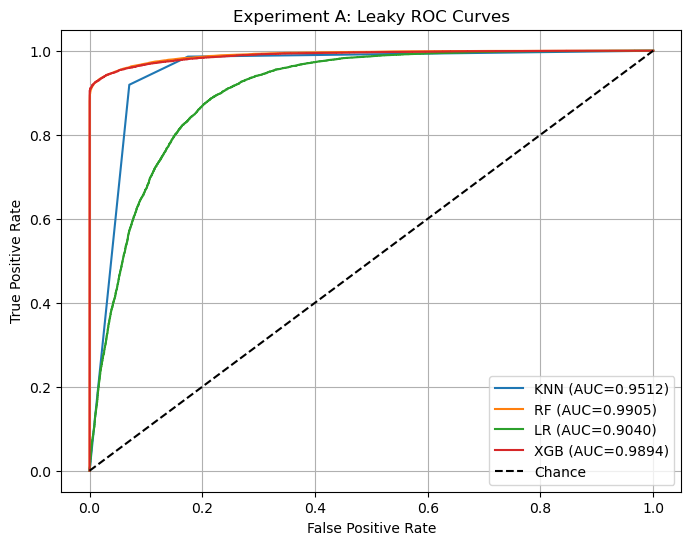

In [11]:
df_A  = build_comparison_table(results_A)

print("\n=== LEAKY Results ===")
print(df_A.round(4))

plot_all_rocs(results_A, title="Experiment A: Leaky ROC Curves")


### 5) EXPERIMENT B — **PROPER**

In [12]:
# ======================================================================
# EXPERIMENT B: PROPER (split first; resample only on the training folds)
# ======================================================================

# Split first; then run SMOTE-ENN ONLY within training via imblearn Pipeline.
print("\n" + "="*70)
print("EXPERIMENT B: PROPER (split first; resample only on the training folds)")
print("="*70)


# Run ALL models
results_B = {}


for name in model_names:
    print(f"\n--- Training {name.upper()} ---")
    start = time.time()
    pipe = make_pipeline(model_name=name, leaky=False, smoteenn=smoteenn)
    pipe.fit(X_train, y_train)
    results_B[name] = evaluate(pipe, X_test, y_test, f"PROPER {name.upper()}")
    end = time.time()
    elapsed = end - start
    print(f"Time taken for {name.upper()}: {elapsed:.2f} seconds\n\n")

print("\nCompleted Experiment B (Proper).")



EXPERIMENT B: PROPER (split first; resample only on the training folds)

--- Training KNN ---
[PROPER KNN] ROC computed: 4 points
Time taken for KNN: 19.43 seconds



--- Training RF ---
[PROPER RF] ROC computed: 296 points
Time taken for RF: 48.96 seconds



--- Training LR ---
[PROPER LR] ROC computed: 2637 points
Time taken for LR: 9.31 seconds



--- Training XGB ---
[PROPER XGB] ROC computed: 2759 points
Time taken for XGB: 9.27 seconds



Completed Experiment B (Proper).



=== PROPER (B) Results ===
           AUC     ACC      F1  Precision  Recall  Specificity
Method                                                        
KNN     0.7057  0.7712  0.2892     0.1946  0.5626       0.7900
RF      0.8279  0.8398  0.3658     0.2720  0.5584       0.8652
LR      0.8378  0.6868  0.3099     0.1895  0.8502       0.6720
XGB     0.8191  0.8641  0.3584     0.2939  0.4590       0.9006


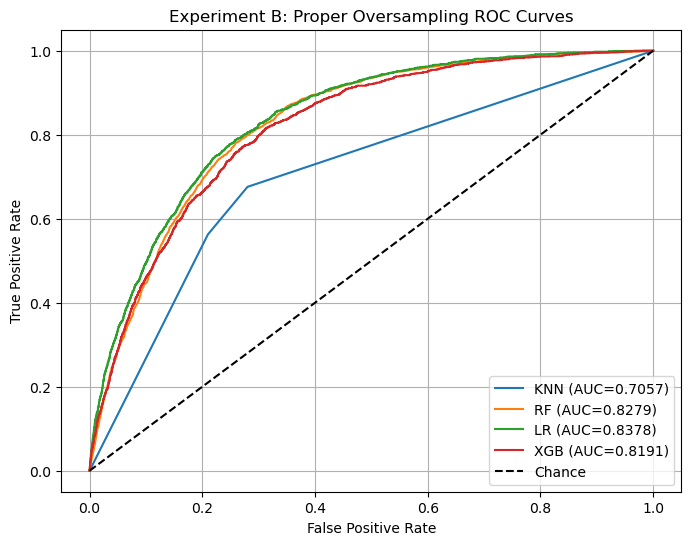

In [13]:
df_B  = build_comparison_table(results_B)

print("\n=== PROPER (B) Results ===")
print(df_B.round(4))

plot_all_rocs(results_B, title="Experiment B: Proper Oversampling ROC Curves")


### 6) EXPERIMENT C — **PROPER** RandomUnderSampler applied BEFORE split

In [14]:
# ======================================================================
# EXPERIMENT C: PROPER (RandomUnderSampler applied BEFORE split)
# ======================================================================
print("\n" + "="*70)
print("EXPERIMENT C: PROPER (RandomUnderSampler applied BEFORE split)")
print("="*70)

rus = RandomUnderSampler(random_state=random_state, sampling_strategy="auto")

# 1) Apply undersampling globally (this is the 'leaky' mistake)
X_leaky_us, y_leaky_us = rus.fit_resample(X_all, y_all)
print(f"After RandomUnderSampler (global): rows={len(X_leaky_us):,}, "
      f"positives={(y_leaky_us==1).sum():,}, negatives={(y_leaky_us==0).sum():,}")

# 2) Split AFTER resampling (leakage!)
Xtr_L_us, Xte_L_us, ytr_L_us, yte_L_us = train_test_split(
    X_leaky_us, y_leaky_us,
    test_size=TEST_SIZE,
    random_state=random_state,
    stratify=y_leaky_us
)

# 3) Run ALL models
model_names = ["knn", "rf", "lr", "xgb"]  # add "nb", "svc", "ann" later if needed
results_C = {}

for name in model_names:
    print(f"\n--- Training {name.upper()} (Undersample) ---")
    start = time.time()
    pipe = make_pipeline(model_name=name, leaky=True)  # still "leaky" since resampling was global
    pipe.fit(Xtr_L_us, ytr_L_us)
    results_C[name] = evaluate(pipe, Xte_L_us, yte_L_us, f"LEAKY-US {name.upper()}")
    end = time.time()
    print(f"Time taken for {name.upper()}: {end-start:.2f} seconds\n")

print("\nCompleted Experiment C (Random Undersampling).")



EXPERIMENT C: PROPER (RandomUnderSampler applied BEFORE split)
After RandomUnderSampler (global): rows=55,642, positives=27,821, negatives=27,821

--- Training KNN (Undersample) ---
[LEAKY-US KNN] ROC computed: 4 points
Time taken for KNN: 2.24 seconds


--- Training RF (Undersample) ---
[LEAKY-US RF] ROC computed: 298 points
Time taken for RF: 17.97 seconds


--- Training LR (Undersample) ---
[LEAKY-US LR] ROC computed: 6396 points
Time taken for LR: 0.40 seconds


--- Training XGB (Undersample) ---
[LEAKY-US XGB] ROC computed: 5855 points
Time taken for XGB: 1.37 seconds


Completed Experiment C (Random Undersampling).



=== C Results ===
           AUC     ACC      F1  Precision  Recall  Specificity
Method                                                        
KNN     0.7279  0.6605  0.5961     0.7354  0.5012       0.8197
RF      0.8259  0.7549  0.7656     0.7335  0.8005       0.7092
LR      0.8352  0.7613  0.7687     0.7455  0.7933       0.7292
XGB     0.8125  0.7404  0.7479     0.7270  0.7699       0.7109


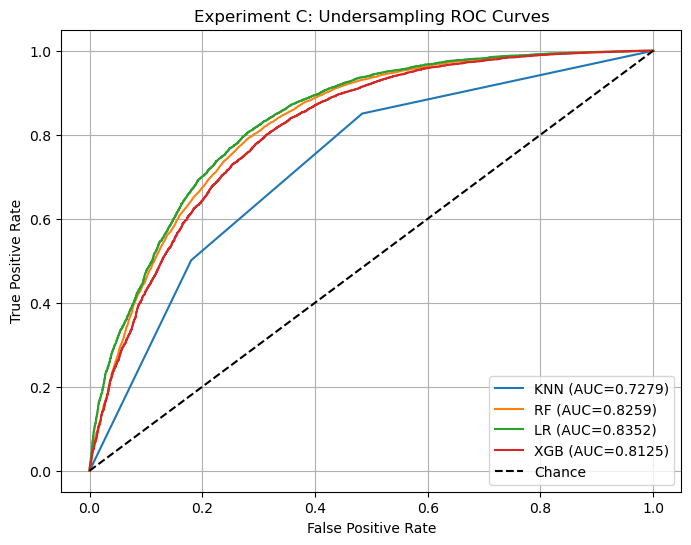

In [15]:
df_C  = build_comparison_table(results_C)

print("\n=== C Results ===")
print(df_C.round(4))

plot_all_rocs(results_C, title="Experiment C: Undersampling ROC Curves")
